# Abstraction

We have seen **duck typing** as a convient abstraction tool: 
* As a **user**, we don't have to care about how a specific type, say an `Array`, is implemented. By *being an array* (i.e. a subtype of `AbstractArray`) it behaves like we expect and we can just use it.
* As a **developer**, as long as we make our objects behave like, say, and `AbstractArray`, we can implement it in whatever way we deem appropriate and it will work with all kinds of algorithms.

Building upon this principle, we also want to formulate our **algorithms** in an abstract way such that it works will all kinds of data types irrespective of their precise implementation (or even meaning). This is generally known as **generic programming**.

From [Wikipedia](https://en.wikipedia.org/wiki/Generic_programming):
> **Generic programming** is a style of computer programming in which algorithms are written in terms of types *to-be-specified-later* that are then *instantiated* when needed for specific types provided as parameters.

## Example: Vandermonde matrix

[Vandermonde matrix:](https://en.wikipedia.org/wiki/Vandermonde_matrix)
\begin{align}V=\begin{bmatrix}1&\alpha _{1}&\alpha _{1}^{2}&\dots &\alpha _{1}^{n-1}\\1&\alpha _{2}&\alpha _{2}^{2}&\dots &\alpha _{2}^{n-1}\\1&\alpha _{3}&\alpha _{3}^{2}&\dots &\alpha _{3}^{n-1}\\\vdots &\vdots &\vdots &\ddots &\vdots \\1&\alpha _{m}&\alpha _{m}^{2}&\dots &\alpha _{m}^{n-1}\end{bmatrix}\end{align}

In [1]:
function vander_naive(x::Vector)
    m = length(x)
    V = Matrix{Float64}(undef, m, m)
    for j = 1:m
        V[j,1] = 1.0
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

vander_naive (generic function with 1 method)

In [2]:
vander_naive(rand(3))

3×3 Matrix{Float64}:
 1.0  0.356689  0.127227
 1.0  0.387894  0.150462
 1.0  0.195109  0.0380674

In [3]:
vander_naive(1:3)

LoadError: MethodError: no method matching vander_naive(::UnitRange{Int64})
[0mClosest candidates are:
[0m  vander_naive([91m::Vector[39m) at In[1]:1

In [4]:
vander_naive([1,2,3])

3×3 Matrix{Float64}:
 1.0  1.0  1.0
 1.0  2.0  4.0
 1.0  3.0  9.0

Why is the result a matrix of floating point numbers....?

Even worse:

In [5]:
vander_naive(rand(ComplexF64, 3))

LoadError: InexactError: Float64(0.08231103940257922 + 0.13496758754387972im)

Our algorithm `vander_naive` is not generic! It assumes too much about the input type (it only takes `Vector`s) and also special cases `Float64`. Instead we should try to
* keep function argument types generic if possible
* avoid explicit typing (which is rarely necessary)

In [6]:
function vander_generic(x::AbstractVector{T}) where T
    m = length(x)
    V = Matrix{T}(undef, m, m)
    for j = 1:m
        V[j,1] = one(x[j])
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

vander_generic (generic function with 1 method)

Not only does our code now work in the obvious cases above:

In [7]:
vander_generic(1:3)

3×3 Matrix{Int64}:
 1  1  1
 1  2  4
 1  3  9

In [8]:
vander_generic(rand(ComplexF64, 3))

3×3 Matrix{ComplexF64}:
 1.0+0.0im  0.635483+0.966431im  -0.530151+1.2283im
 1.0+0.0im  0.873143+0.442155im   0.566878+0.772129im
 1.0+0.0im  0.887157+0.992123im   -0.19726+1.76034im

It also extends to data types that we probably didn't even have in mind when writing down the algorithm:

In [9]:
vander_generic([3, "Stadt", 4 + 5im])

3×3 Matrix{Any}:
  1      3           9
   ""     "Stadt"     "StadtStadt"
 1+0im  4+5im      -9+40im

(Note that `*` is string concatenation and `one(String) == ""`, representing the identity element under multiplication.)

### And all of this genericity comes at no performance penality

In [10]:
using BenchmarkTools

In [11]:
x = rand(Float64, 10);
@btime vander_naive($x);
@btime vander_generic($x);

  132.689 ns (1 allocation: 896 bytes)
  130.972 ns (1 allocation: 896 bytes)


Actually, for this specific example **our generic code is faster** in a few cases inasmuch as type conversions are unnecessary.

In [12]:
x = rand(Bool, 10);
@btime vander_naive($x);
@btime vander_generic($x);

  142.808 ns (1 allocation: 896 bytes)
  113.381 ns (1 allocation: 160 bytes)


In [13]:
x = rand(Float32, 10);
@btime vander_naive($x);
@btime vander_generic($x);

  133.060 ns (1 allocation: 896 bytes)
  100.531 ns (1 allocation: 496 bytes)


# Generic Programming + Multiple Dispatch

The possibility to write generic algorithms that compile to fast machine code (a point we will investigate later) in combination with multiple dispatch leads to an ([unreasonable](https://www.youtube.com/watch?v=kc9HwsxE1OY)) amount of code reuse. This sharing of code comes in two forms:
1. **Sharing types**
 * Examples: DataStructures.jl, OrderedCollections.jl, StaticArrays.jl, Colors.jl, Measurements.jl
 * **You can define methods on types after the type is defined!**
 
 
2. **Sharing generic algorithms**
 * Examples: StatsBase.jl, SortingAlgorithms.jl, GenericLinearAlgebra.jl,
 * **Methods are selected based on all argument types**

 <img src="imgs/revdeps.png" alt="drawing" width="800"/>

As of the time of this writing, **~ 800 packages** depend on the data types provided in [DataStructures.jl](https://juliacollections.github.io/DataStructures.jl/latest/).

**~ 900 packages** reuse type implementations in [OrderedCollections.jl](https://github.com/JuliaCollections/OrderedCollections.jl).

**~ 550 packages** reuse [SortingAlgorithms.jl](https://github.com/JuliaCollections/SortingAlgorithms.jl).

**~ 300 packages** reuse [DiffRules.jl](https://github.com/JuliaDiff/DiffRules.jl).

**~ 50 packages** reuse [GenericSVD.jl](GenericSVD.jl).

(~ 5000 packages overall)

# Fancy example of generic programming

In [15]:
using Interact

In [16]:
@manipulate for n in 1:20
    [i*j for i in 1:n, j in 1:n]
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 20, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
10, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/eric/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/eric/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/eric/.julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/home/eric/.julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/home/eric/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f43648f26e0, Task (runnable) @0x00007f43648f26e0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"9756027647344306389\",\"id\":\"5630458630030884079\",\"type\":\"observable\"}),\"index\":WebIO

In [17]:
# generic algorithm
function insert_block(A, i, j, blockvalue)
    B = copy(A)
    B[i:i+2, j:j+2] .= blockvalue
    return B
end

insert_block (generic function with 1 method)

In [18]:
# generic algorithm
function insert_block(A::AbstractMatrix{T}, i::Integer, j::Integer, blockvalue::T) where T
    B = copy(A)
    B[i:i+2, j:j+2] .= blockvalue
    return B
end

insert_block (generic function with 2 methods)

In [19]:
A = fill(0, 9, 9)

9×9 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0

In [20]:
insert_block(A, 3, 5, 1)

9×9 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  1  1  1  0  0
 0  0  0  0  1  1  1  0  0
 0  0  0  0  1  1  1  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0

In [22]:
A = fill(0, 10, 10)
n = size(A, 1)

@manipulate for i in 1:n-2, j in 1:n-2
    insert_block(A, i, j, 1)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 8, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
4, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/eric/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/eric/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/eric/.julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/home/eric/.julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/home/eric/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f43665970f0, Task (runnable) @0x00007f43665970f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"12385900237022393172\",\"id\":\"14479920675175988729\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"12385900237022393172\",\"id\":\"14118414033

### Let's add some color!

Our function `insert_block` is generic. We don't care about the element type of `A`. Pretty much every type is fine!

In [25]:
using Colors

In [26]:
colors = distinguishable_colors(10)

In [27]:
basecolor = colors[1]

In [28]:
accentcolor = colors[4]

In [29]:
A = fill(basecolor, 10, 10)

In [31]:
A = fill(basecolor, 10, 10)
n = size(A, 1)

@manipulate for i in 1:n-2, j in 1:n-2
    insert_block(A, i, j, accentcolor)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 8, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
4, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/eric/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/eric/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/eric/.julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/home/eric/.julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/home/eric/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f43cf3d73d0, Task (runnable) @0x00007f43cf3d73d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"13088642524303829574\",\"id\":\"15813956061415793708\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"13088642524303829574\",\"id\":\"72974513487

## Emergent features: Example DifferentiaEquations.jl

$$\frac{du(t)}{dt} = -cu(t)$$

In [32]:
using OrdinaryDiffEq

#Half-life of Carbon-14 is 5730 years.
c = 5.730

#Setup
u0 = 1.0
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)

LoadError: ArgumentError: Package OrdinaryDiffEq not found in current path:
- Run `import Pkg; Pkg.add("OrdinaryDiffEq")` to install the OrdinaryDiffEq package.


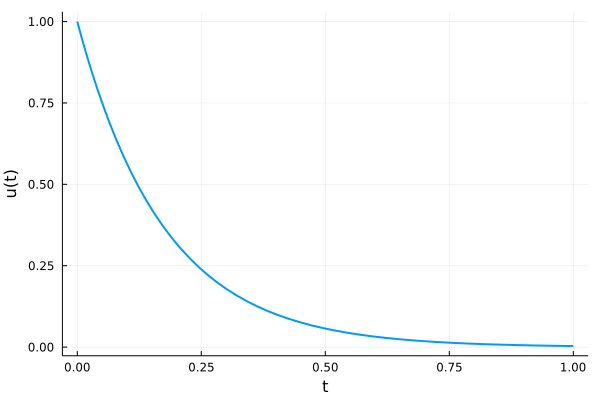

In [38]:
using OrdinaryDiffEq, Measurements, Plots

#Half-life of Carbon-14 is 5730 years.
c = big(5.730) # now a BigFloat

#Setup
u0 = big(1.0) # now a BigFloat
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

plot(sol.t, sol.u, ylabel="u(t)", xlabel="t", lw=2, legend=false)

In [39]:
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

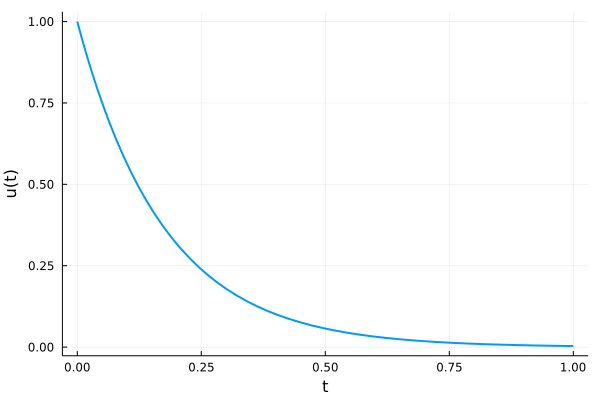

In [40]:


using Plots

plot(sol.t, sol.u, ylabel="u(t)", xlabel="t", lw=2, legend=false)




## Arbitrary precision


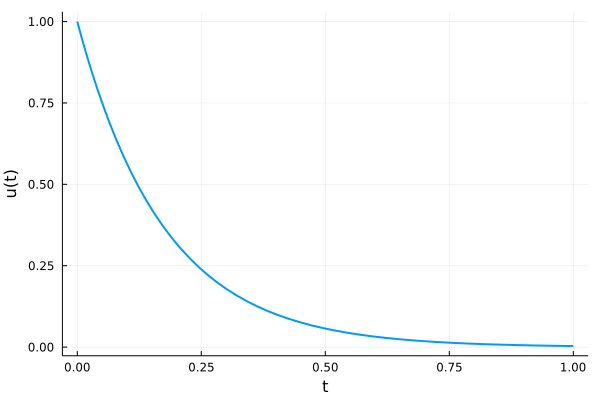

In [43]:
using OrdinaryDiffEq, Measurements, Plots

#Half-life of Carbon-14 is 5730 years.
c = big(5.730) # now a BigFloat

#Setup
u0 = big(1.0) # now a BigFloat
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

plot(sol.t, sol.u, ylabel="u(t)", xlabel="t", lw=2, legend=false)


In [44]:
sol.u

48-element Vector{BigFloat}:
 1.0
 0.9677886860242480802598783250713916010081415505397800881445406271537611300017618
 0.9315211281525870696951220469884643089015968992100693760200740553948355529147443
 0.8884024345211743249328056132581922926713349550779312851128595145794638309367323
 0.8418375252286853693374875453327959298310268751540882123064603835469502333473109
 0.7919476716556936759645062652642499184136681143994639131997461417941721267832523
 0.7407016330428085395088677734469248742771667496689773395471797310606867824210415
 0.6889166340726772080759580717731892548533466681449545296259777043743101381792959
 0.6377469702849522203007041715785847992156324337145518931818644468122003575559061
 0.5878693938054670387069845142083170215958396547725714928808722707474449713312153
 0.5398978925292378408930959222823291015539152628089942039187986374217863041478433
 0.4942059991356295169324189779662222956173429318011563947151762335740927377004429
 0.45105483823768315658978729434496926727679744366517

### With uncertainties: Measurements.jl

`Measurement` type from [Measurements.jl]() and differential equation solver from [OrdinaryDiffEq.jl](https://github.com/JuliaDiffEq/OrdinaryDiffEq.jl) (i.e. [DifferentialEquations.jl](https://github.com/JuliaDiffEq/DifferentialEquations.jl))

In [45]:
using Measurements

In [46]:
1 ± 0.1

1.0 ± 0.1

In [47]:
(1 ± 0.1) * (2 ± 0.05)

2.0 ± 0.21

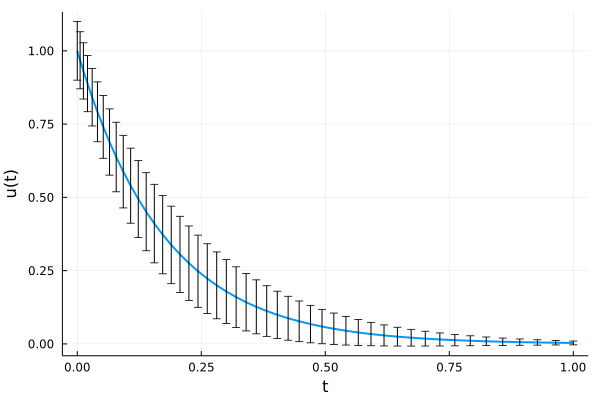

In [48]:
using OrdinaryDiffEq, Measurements, Plots

#Half-life of Carbon-14 is 5730 years.
c = 5.730 ± 2

#Setup
u0 = 1.0 ± 0.1
tspan = (0.0, 1.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

plot(sol.t, sol.u, ylabel="u(t)", xlabel="t", lw=2, legend=false)

Note that, in some sense, **Julia implemented that feature by itself**.

The authors of Measurements.jl and DifferentialEquations.jl never had any collabration on this.

It **just works**.

## Symbolic computations

Let's compute the Vandermonde matrix symbolically.


\begin{align}V=\begin{bmatrix}1&\alpha _{1}&\alpha _{1}^{2}&\dots &\alpha _{1}^{n-1}\\1&\alpha _{2}&\alpha _{2}^{2}&\dots &\alpha _{2}^{n-1}\\1&\alpha _{3}&\alpha _{3}^{2}&\dots &\alpha _{3}^{n-1}\\\vdots &\vdots &\vdots &\ddots &\vdots \\1&\alpha _{m}&\alpha _{m}^{2}&\dots &\alpha _{m}^{n-1}\end{bmatrix}\end{align}

In [51]:
using SymPy

In [52]:
@vars a b c d e

(a, b, c, d, e)

In [53]:
sin(a)sin(b)+cos(a)*cos(b)

sin(a)⋅sin(b) + cos(a)⋅cos(b)

In [54]:
simplify(ans)

cos(a - b)

In [55]:
vander_generic([a,b,c,d,e])

5×5 Matrix{Sym}:
 1  a  a^2  a^3  a^4
 1  b  b^2  b^3  b^4
 1  c  c^2  c^3  c^4
 1  d  d^2  d^3  d^4
 1  e  e^2  e^3  e^4

(See [Symbolics.jl](https://github.com/JuliaSymbolics/Symbolics.jl) for a pure-Julia SymPy replacement.)

# Core messages of this Notebook

* It is simple to write **type-generic code** in Julia and you should do it.
* Generally, **generic code is just as fast as specific code**.
* Generic Programming + Multiple Dispatch = **lots of code sharing and emergent features**